# Hashtag analysis

## Long code, fast execution: create multiple new entities and assemble hashtags

This code creates new fields with multiple hashtags for each tweet and one field with popular hashtags.
Credits go to [Our Coding Club and James](https://ourcodingclub.github.io/tutorials/topic-modelling-python/).

Some preprocessing in the form of new modules:

In [1]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import nan

# model building package
import sklearn

# package to clean text
import re

And let's define the main variables. Execute **only one** of the two following blocks of code

I load two data frames, one with uppercase (data) and one with lowercase (df). This is a great way to quickly compare

In [54]:
src = '/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data'

data = pd.read_csv(join(src, 'Radverkehr.csv'), encoding='utf-8', dtype='str', 
                   parse_dates=['created_at'])
df = pd.read_csv(join(src, 'Bahnverkehr.csv'), encoding='utf-8', dtype='unicode', 
                   parse_dates=['created_at']).apply(lambda x: x.astype(str).str.lower())
# df = df.astype(str)

In [56]:
# This code only work with the first file selection above
def find_hashtags(text):
    '''This function will extract hashtags'''
    return re.findall('(?:^|\s)[＃#]{1}(\w+)', text, re.UNICODE) # The original code uses another section to find hashtags, which does not work for German: (#[A-Za-z]+[A-Za-z0-9-_]+)

df['hashtags'] = df.text.apply(find_hashtags, lambda col: col.str.lower())

df['hashtags']

0                                                       []
1                                                       []
2                                                       []
3        [laschet, bahn, radwege, emobility, laschetzer...
4                                       [fff, klimawandel]
                               ...                        
54211                              [liberalisierung, bahn]
54212                                               [oebb]
54213                                         [müllverein]
54214                                               [oebb]
54215                                                   []
Name: hashtags, Length: 54216, dtype: object

In [47]:
src = "/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Greenwashing"

fields = ['entities.hashtags', 'created_at', 'text', 'entities.urls']

df = pd.read_csv(join(src, 'greenwashing.csv'), encoding='utf-8', dtype='unicode', 
                   parse_dates=['created_at'], usecols=fields)

## Get URLs

In [7]:
# This code only executes with the second file section directly above
def find_urls(tagstring):
    if tagstring == tagstring:
        list_of_dicts = eval(tagstring)
        urls = []
        for dct in list_of_dicts:
            tag = dct['expanded_url']
            urls.append(tag)
        return urls
    else:
        return np.nan
    
df['urls'] = df['entities.urls'].apply(find_urls, lambda col: col.str.lower())

df = df.dropna(subset=['urls']) # delete empty rows

In [12]:
# take the rows from the hashtag columns where there are actually hashtags
urls_list_df = df.loc[
                       df.urls.apply(lambda hashtags_list: hashtags_list !=[]),['urls']]

# print hashtags per User
#urls_list_df
urls_list_df.to_csv('/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Greenwashing/greenwashing_urls.csv') # perhaps add , index=False

## Get Hashtags

In [13]:
# This code only executes with the second file section directly above
def find_hashtags(tagstring):
    if tagstring == tagstring:
        list_of_dicts = eval(tagstring)
        hashtags = []
        for dct in list_of_dicts:
            tag = dct['tag']
            hashtags.append(tag)
        return hashtags
    else:
        return np.nan
    
df['hashtags'] = df['entities.hashtags'].apply(find_hashtags, lambda col: col.str.lower())

df = df.dropna(subset=['hashtags']) # delete empty rows

In [14]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = df.loc[
                       df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]

# print hashtags per User
hashtags_list_df

,hashtags
0,"[Federer, Wimbledon, GodBlessTheMyth]"
2,[IE]
14,"[CDU, CDUWahlprogramm, Laschet]"
15,"[CDU, CDUWahlprogramm, Laschet]"
16,"[CDU, CDUWahlprogramm, Laschet]"
...,...
943208,"[greenwashing, fairwashing, communication]"
943221,"[wiunion, wimine]"
943222,"[wiunion, wimine]"
943223,"[wiunion, wimine]"


In [15]:
# create dataframe where each use of hashtag gets its own row. The complicated function is called "list comprehension"
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])


# flattened_hashtags_df

# number of unique hashtags
flattened_hashtags_df['hashtag'].unique().size

75950

The next cell introduces preprocessing to produce more thorough frequencies and increase validity. However, some of these are subjective decisions that need to reflect the conventions and phrases common in a data set.

greenwashing.csv

In [19]:
# Merge certain similar terms
## Option 1: Select and replace individually with a lamba loop. Quick and dirty, slow execution
## flattened_hashtags_df['hashtag'] = flattened_hashtags_df['hashtag'].apply(
##    lambda x: x.replace("fahrrad", "Fahrrad")) # Merge certain singular words

## Option 2: Select and replace with one call and regex. More elegant.
## Preprocessing hashtags for Radverkehr.csv

flattened_hashtags_df['hashtag'] = flattened_hashtags_df.replace({'hashtag' : 
                                                                  {'greenwashing' : 'Greenwashing', 'GreenWashing' : 'Greenwashing',
                                                                   'GREENWASHING': 'Greenwashing',
                                                                   'climatechange' : 'ClimateChange',
                                                                   'climateaction' : 'ClimateAction',
                                                                   'CLIMATEACTION' :'ClimateAction',
                                                                   'climate' : 'Climate',
                                                                   'CLIMATE' : 'Climate',
                                                                   'co2' : 'CO2',
                                                                   'klima' : 'Klima', 'environnement' : 'Environment',
                                                                   'sustainability': 'Sustainability',
                                                                   'csr' : 'CSR', 'climat' : 'Climate',
                                                                   'environment' : 'Environment'}
                                                                 }, regex=True)
                                                                

# Remove punctuation (should be removed anyways)
# flattened_hashtags_df['hashtag'] = flattened_hashtags_df['hashtag'].str.replace('[^\w\s]','', regex=True)

In [22]:
# Print the top 10
flattened_hashtags_df.value_counts('hashtag')[0:10]
#flattened_hashtags_df.to_csv('/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Greenwashing/greenwashing_top_hashtags.csv')

hashtag
Greenwashing      94028
Climate            5047
Sustainability     4602
StopFakeGreen      4394
ClimateChange      4114
COP21              2927
ClimateAction      2841
ESG                2654
taxonomy           2382
Environment        2342
dtype: int64

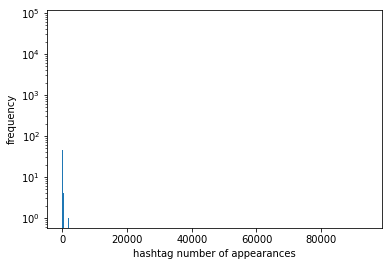

In [23]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

# number of times each hashtag appears
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonpositive='clip')
plt.show()


## Vectorization: See how hashtags are related to each other
Let's prepare data first. Adjust min_appearance based on frequencies.

In [36]:
# take hashtags which appear at least this amount of times. Increase min_appearance if graph below is too large
min_appearance = 600
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]


for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

# hashtag_vector_df.head # Uncommen this to see how the vector is coded

In [37]:
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

# calculate the correlation matrix
correlations = hashtag_matrix.corr()

### Correlation matrix: seaborn

Now this is what we're doing below:
We want to find the correlation between each column of the dataframe and thus the correlation between the different hashtags appearing in the same tweets.
As defined above, e can’t correlate hashtags which only appear once, and we don’t want hashtags that appear a low number of times since this could lead to spurious correlations.

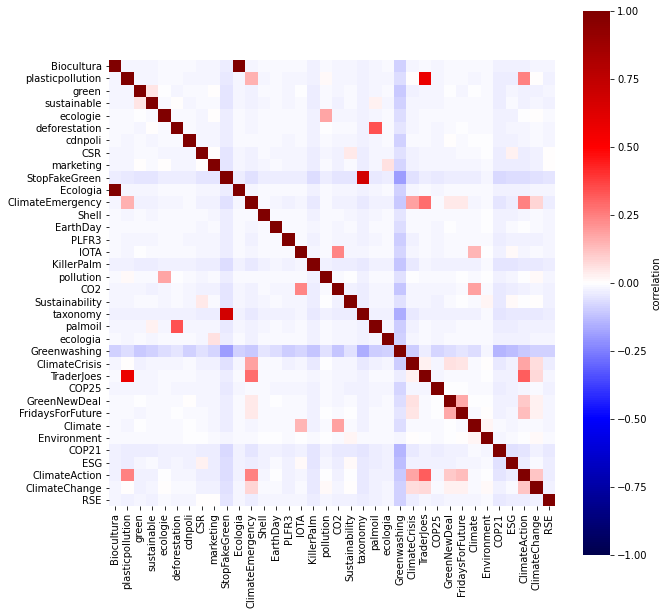

In [39]:
import seaborn as sns

# model building package
import sklearn

# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='seismic', # RdBu, GnBu, seismic, bwr, magma More https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
    vmin=-1,
    vmax=1,
    square = True,
    # annot = True, fmt='.1', # To get numbers
    cbar_kws={'label':'correlation'}) # perhaps include , 'orientation': 'horizontal'


plt.savefig("/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/plots/Greenwashing/hashtag_correlation_greenwashing.jpeg", dpi=400)
plt.show()

### Correlation matrix: heatmapz
The difference below is that we get the size of correlation, which is directly related to the colour. Readability is thus improved. In addition, this graph includes all terms that match the minimal requirements (the graph above cuts information based on the maximum size of the graph). More [info on the module's website](https://pypi.org/project/heatmapz/)

In [40]:
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [41]:
# !pip install heatmapz

In [42]:
# Import the two methods from heatmap library
from heatmap import heatmap, corrplot

Create correlation matrix with size

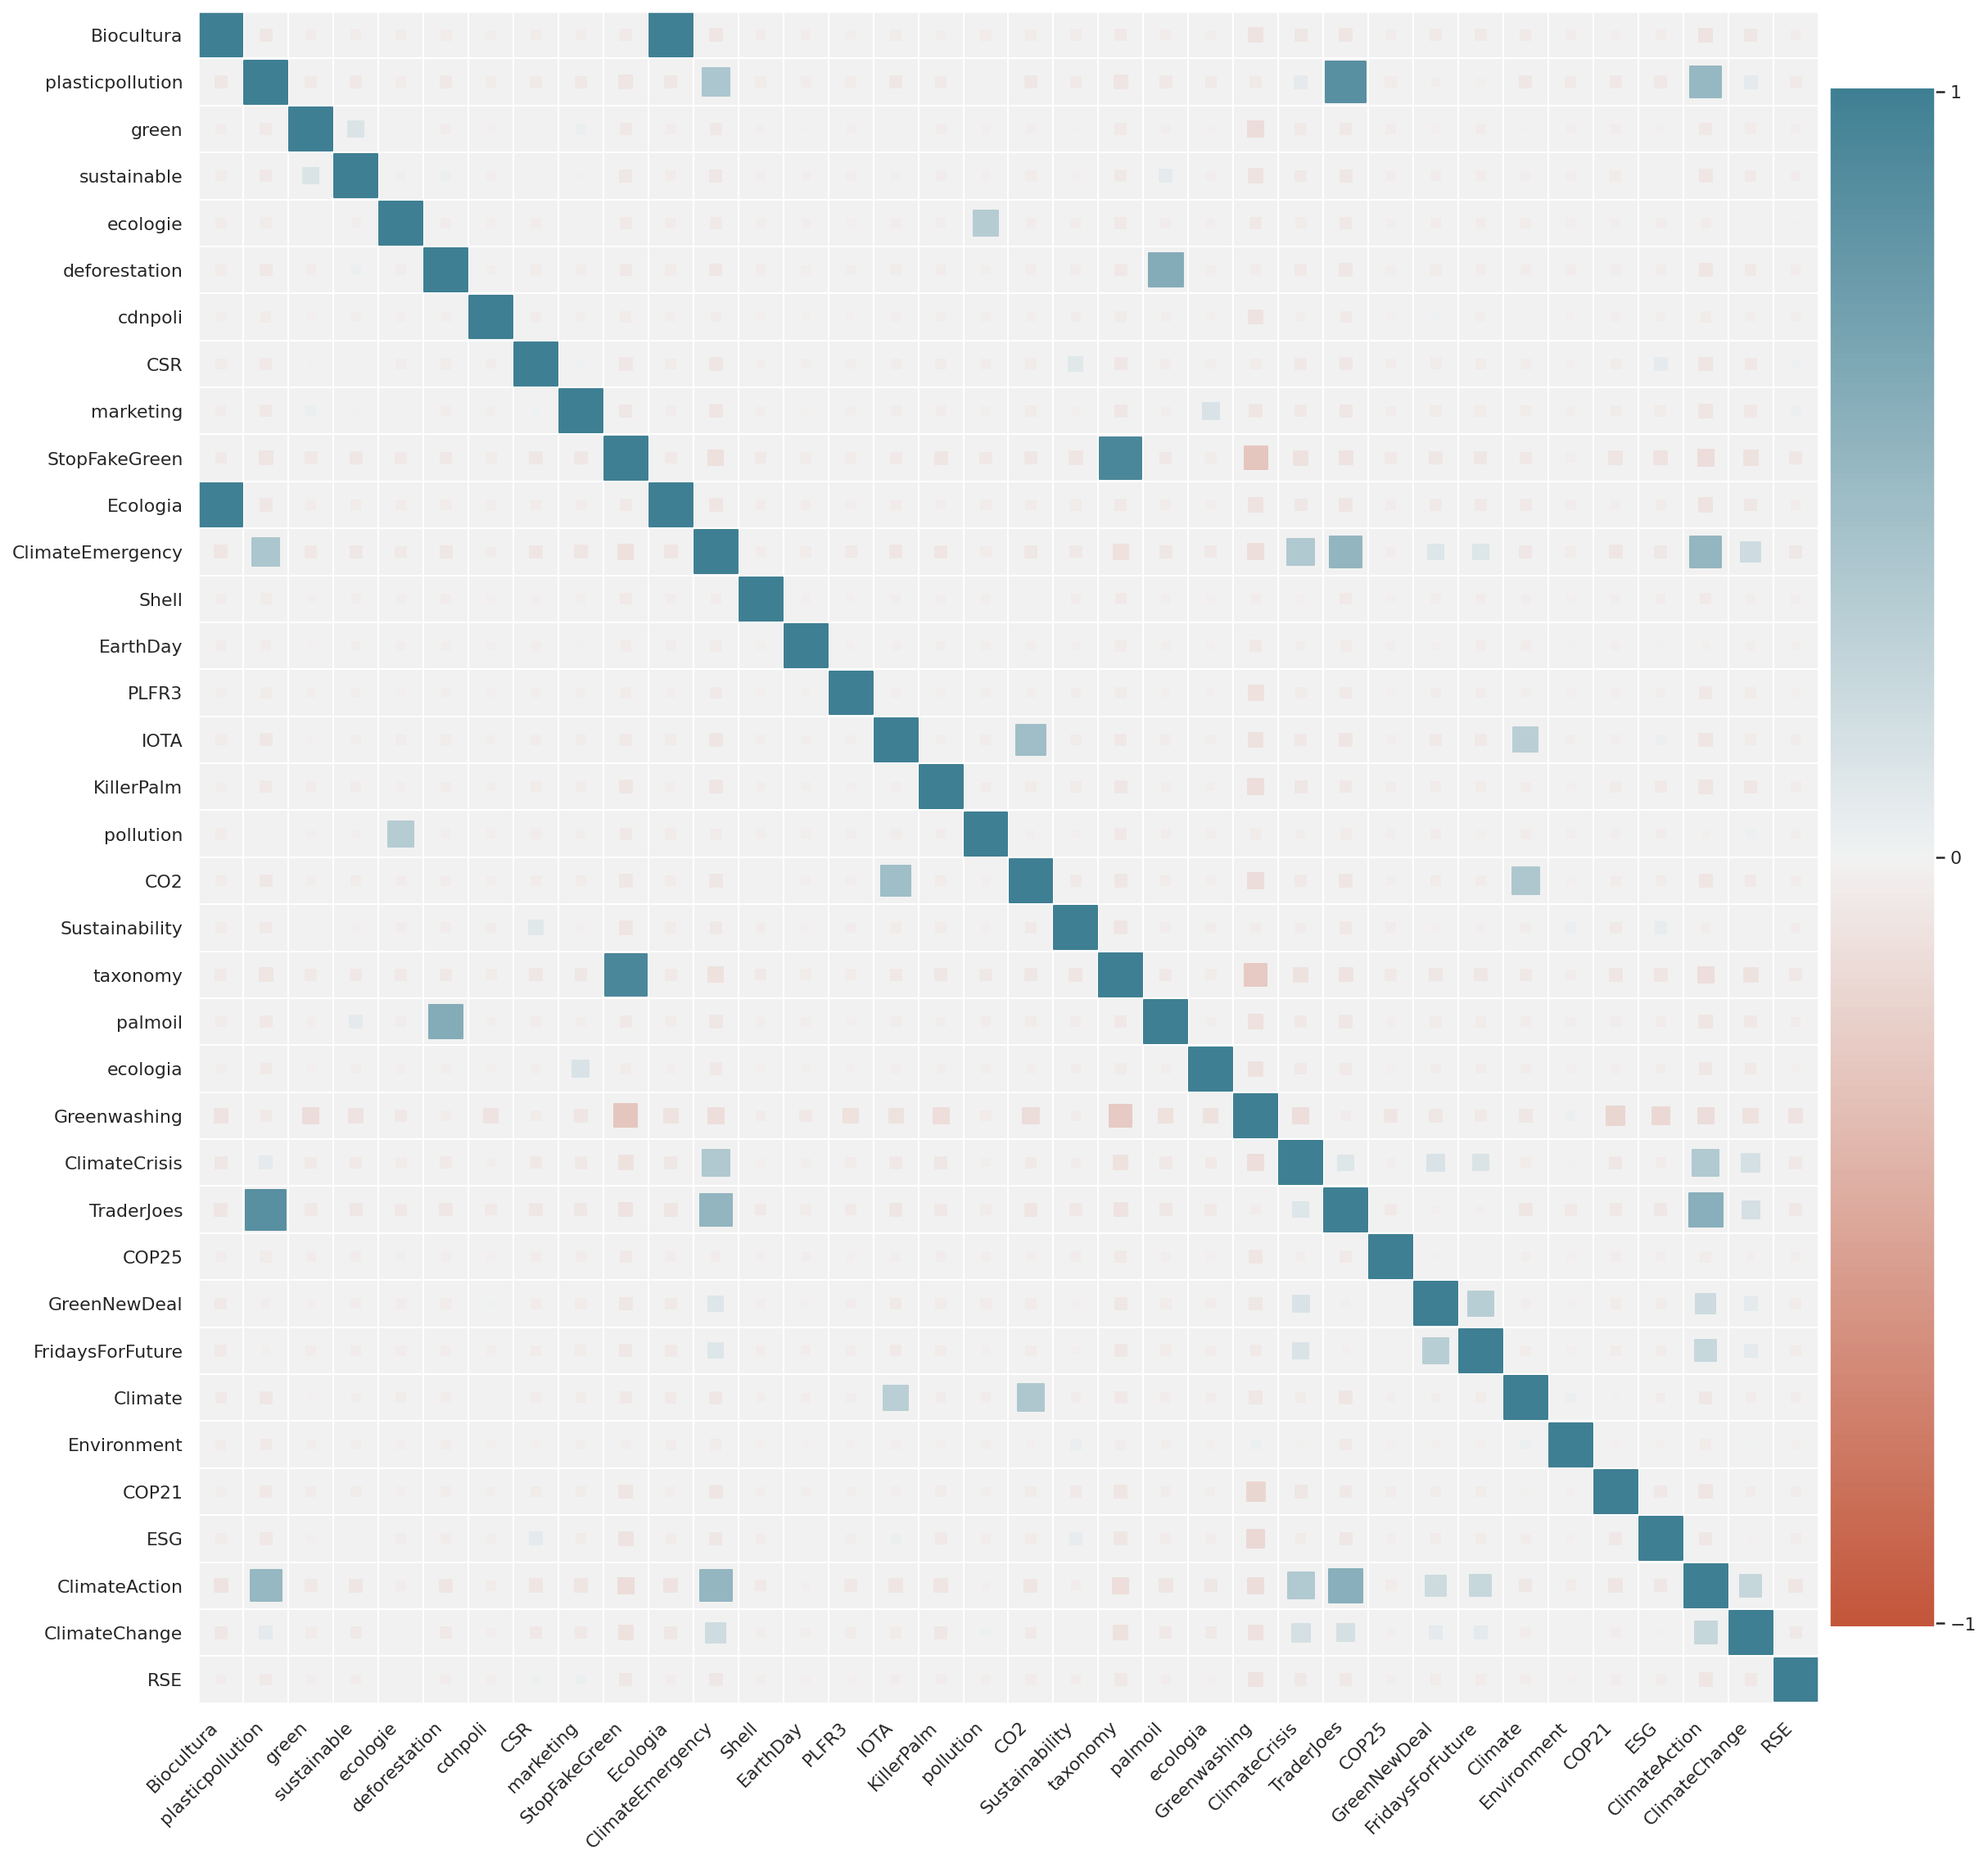

In [45]:
rcParams['figure.figsize'] = 17,17 
sns.set(color_codes=True, font_scale=1)
plt.figure(figsize=(19, 19))
corrplot(correlations.corr(), size_scale=700) 
# Adjust size-scale according to figure size. 
# Increasing the scale improves readability but also distorts
# Use marker='' for different shapes. 
# See also https://matplotlib.org/stable/api/markers_api.html
# For colours see https://seaborn.pydata.org/tutorial/color_palettes.html

plt.savefig("/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/plots/Greenwashing/hashtag_correlation_greenwashing_heatmapz.jpeg", dpi=400)

# Topic Modelling/Valoyant text preparation

To make topic topelling possible, you need to strip the text of all insignificant strips of words and make them as coherent as possible without losing quality. Key to this is a cleaning master function.

In [51]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import nan

# alternative model building package
# import sklearn
# from sklearn.decomposition import NMF

# package to clean text
import re

# Load modules for cleaning tasks
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import GermanStemmer

In [52]:
src = "/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Greenwashing"

fields = ['entities.hashtags', 'created_at', 'text', 'entities.urls']

df = pd.read_csv(join(src, 'greenwashing.csv'), encoding='utf-8', dtype='unicode', 
                   parse_dates=['created_at'], usecols=fields)

In [48]:
# Standard cleaning tasks

def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('RT @[\w_]+:', '', tweet) # remove retweet ## Alternatives: RT @[\w_]+: OR (RT\s@[A-Za-z]+[A-Za-z0-9-_]+)
    tweet = re.sub('@[A-Za-z0-9_]', '', tweet) # remove tweeted at ## Alternatives: @[A-Za-z0-9_]+ OR (@[A-Za-z]+[A-Za-z0-9-_]+)
    return tweet

my_stopwords = nltk.corpus.stopwords.words('german', 'english')
word_rooter = nltk.stem.snowball.GermanStemmer(ignore_stopwords=False).stem
#word_rooter2 = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
#my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@' ## Alternatives: r'[^\w\s] OR !"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@ 

# cleaning master function
def clean_tweet(tweet, bigrams=False): # change bigrams to True to enable further analysis
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    #tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub(r'[^\w\s]', ' ', tweet) # strip punctuation
    tweet = re.sub(r'\b\w{1,3}\b', '', tweet, re.UNICODE)
    tweet = re.sub('\s+', ' ', tweet, re.UNICODE) # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet, re.UNICODE) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords
    tweet_token_list = [word_rooter(word) if '#' not in word else word 
                        for word in tweet_token_list] # apply word rooter
    #tweet_token_list = [word_rooter2(word) if '#' not in word else word 
    #                    for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [53]:
df['clean_tweet'] = df.text.apply(clean_tweet) # This gets cleaned tweets

#df['clean_tweet'] = df['clean_tweet'].apply(
#    lambda x: x.replace("test", "")) # Merge certain singular words

TypeError: expected string or bytes-like object

In [49]:
df['clean_tweet']

0        anteil unbefristet mittelbau berlin universita...
2                gibt eigent schon viel  mem vswisszeitvg 
3                gibt eigent schon viel  mem vswisszeitvg 
4         institution ieluni wissenschaft mitarbeit inn...
6        this seem trend lik  nsf_ch tries explain what...
                               ...                        
63725     forsch denk wiss vernunft arbeitsvertrag brau...
63726                                         alternativ  
63734      nich mirjam kolonialgeschicht gerad verfasst...
63738      nich mirjam kolonialgeschicht gerad verfasst...
63748     tok jahr germanist linguist forschung beschaf...
Name: clean_tweet, Length: 41216, dtype: object